<a href="https://colab.research.google.com/github/imranmurtaza110/RL_Lunar_lander/blob/main/lunar_lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium
!pip install swig
!apt-get install -y python-box2d
!pip install gymnasium[box2d]
!pip install pyvirtualdisplay
!apt-get update
!apt-get install -y xvfb
!apt-get update
!apt-get install -y xvfb python-opengl ffmpeg swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-box2d
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376097 sha256=c3ddf365f79defd73ff033526f886756847ec490b2fe4a6b39aaeb67825c2d3c
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://ar

In [2]:
from pyvirtualdisplay import Display
from IPython.display import display as ipy_display, HTML
from base64 import b64encode
display = Display(visible=0, size=(1400, 900))
display.start()

from gymnasium.wrappers import RecordVideo

In [3]:
import gymnasium as gym

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class DeepQLearning(nn.Module):
  def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

  def forward(self, x):
    return self.model(x)

In [5]:
class LossFunction:
  def __init__(self, model):
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

  def step(self, loss):
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


In [6]:
import numpy as np
import random

class Agent:
  def __init__(self, action_space, observation_space, model):
    self.action_space = action_space
    self.observation_space = observation_space
    self.epsilon = 0.1
    self.epsilon_decay = 0.00005
    self.experience_buffer = []
    self.model = model
    self.optimizer = LossFunction(self.model)


  def select_action(self, state):
    if np.random.random() < self.epsilon:
        return np.random.randint(self.action_space)
    else:
        if not state[1]:
          state_tensor = torch.FloatTensor(state[0][0:8]).unsqueeze(0)
        else:
          state_tensor = torch.FloatTensor(state).unsqueeze(0)

        act_values = self.model(state_tensor)
        return torch.argmax(act_values).item()


  def experience_replay_buffer(self, state, action, reward, next_state, done):
      self.experience_buffer.append((state, action, reward, next_state, done))


  def play(self, batch_size, gamma):
        if len(self.experience_buffer) < batch_size:
            return

        batch = random.sample(self.experience_buffer, batch_size)

        states = []
        actions = []
        rewards = []
        next_states = []
        is_done = []

        for experience in batch:
            state, action, reward, next_state, done = experience
            states.append(experience[0])
            actions.append(experience[1])
            rewards.append(experience[2])
            next_states.append(experience[3])
            is_done.append(experience[4])

        states_flat = []
        for entry in states:
            if isinstance(entry, tuple) and len(entry) == 2:  # Check if entry is a nested tuple
                states_flat.append(entry[0])  # Append the array from the nested tuple
            else:
                states_flat.append(entry)  # Otherwise, append the array directly

        # Convert states_flat to tensor
        states_tensor = torch.tensor(states_flat, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        is_done = torch.tensor(is_done, dtype=torch.float32)

        q_values = self.model(states_tensor)
        next_q_values = self.model(next_states)

        target_q_values = self.calculate_q_values(rewards, gamma, next_q_values, is_done)

        loss = nn.MSELoss()(q_values[range(batch_size), actions], target_q_values)

        self.optimizer.step(loss)
        self.epsilon -= self.epsilon_decay

  # bellman equation
  def calculate_q_values(self, rewards, gamma, next_q_values, is_done):
    target_q_values = []
    for i in range(len(rewards)):
        if is_done[i] == 0:
            target_q = rewards[i]
        else:
            target_q = rewards[i] + gamma * torch.max(next_q_values[i]) * (1 - is_done[i])

        target_q_values.append(target_q)
    target_q_values = torch.tensor(target_q_values)
    return target_q_values

In [9]:
# Create the environment
import time
env = gym.make("LunarLander-v2",
               render_mode="rgb_array"
               )


video_folder = "/content/videos"

folder = video_folder + f"/episode_{2}"
# env = RecordVideo(env, video_folder = folder)
# wrap the env in the record video
env = gym.wrappers.RecordVideo(env, video_folder, name_prefix="video-", episode_trigger=lambda x: x % 10 == 0)
observation_shape = env.observation_space.shape

num_actions = env.action_space.n
model = DeepQLearning()

# Initialize the agent
agent = Agent(num_actions, observation_shape, model)

# Main loop
steps = []
total_episodes = []
step_rewards = []
episode_rewards = []
time_limit_seconds = 30
# env reset for a fresh start
observation, info = env.reset()
env.start_video_recorder()
for i in range(100):
    state = env.reset()
    total_reward = 0
    start_time = time.time()
    for j in range(1000):  # Maximum episode length
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.experience_replay_buffer(state, action, reward, next_state, done)
        state = next_state
        agent.play(batch_size=32, gamma=0.99)
        total_reward += reward

        elapsed_time = time.time() - start_time

        # if i > 50:
        #   if j % 50 == 0:
        #     print('episode: ' + str(i))
        #     print('iteration: ' + str(j))
        #     print('action: ' + str(action))
        #     print('reward: ' + str(reward))
        #     print('total_reward: ' + str(total_reward))
        #     print('\n\n')

        if done or elapsed_time >= time_limit_seconds or j==999:
            done = True
            steps.append(i+1)
            total_episodes.append(j)
            episode_rewards.append(total_reward)
            print('total episodes: ' + str(i))
            print('total time: ' + str(elapsed_time))
            print('total steps to complete the episode: ' + str(j))
            print('reward for current state: ' + str(reward))
            print('reward for this episode: ' + str(total_reward))
            print('\n')
            break

    #if (i+1) % 10 == 0:
        # folder = video_folder + f"/episode_{1}"
        #env = RecordVideo(env, video_folder = folder, name_prefix=f"episode_{i+1}")
    env.render()
# Close the environment
env.close_video_recorder()
env.close()


Moviepy - Building video /content/videos/video--episode-0.mp4.
Moviepy - Writing video /content/videos/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-0.mp4


Moviepy - Building video /content/videos/video--episode-0.mp4.
Moviepy - Writing video /content/videos/video--episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-0.mp4
total episodes: 0
total time: 1.6141483783721924
total steps to complete the episode: 112
reward for current state: -100
reward for this episode: -473.47526664371105


total episodes: 1
total time: 0.23162126541137695
total steps to complete the episode: 65
reward for current state: -100
reward for this episode: -40.18677192085114


total episodes: 2
total time: 0.21460461616516113
total steps to complete the episode: 65
reward for current state: -100
reward for this episode: -141.81291528877392


total episodes: 3
total time: 0.2702450752258301
total steps to complete the episode: 71
reward for current state: -100
reward for this episode: -204.5457044286348


total episodes: 4
total time: 0.20870399475097656
total steps to complete the episode: 54
reward for current state: -100
reward for this episode: -186.063816396474


total episodes: 5
total time: 0.2141742706298828
total steps to complete the episode: 59


Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-10.mp4
total episodes: 10
total time: 0.824317455291748
total steps to complete the episode: 54
reward for current state: -100
reward for this episode: -215.26250232133918


total episodes: 11
total time: 0.2443692684173584
total steps to complete the episode: 67
reward for current state: -100
reward for this episode: -332.26823826683363


total episodes: 12
total time: 0.2721874713897705
total steps to complete the episode: 76
reward for current state: -100
reward for this episode: -286.62913601723056


total episodes: 13
total time: 0.2831408977508545
total steps to complete the episode: 70
reward for current state: -100
reward for this episode: -313.5839690788837


total episodes: 14
total time: 0.221604585647583
total steps to complete the episode: 59
reward for current state: -100
reward for this episode: -126.39940564495068


total episodes: 15
total time: 0.2838611602783203
total steps to complete the episode:

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-20.mp4
total episodes: 20
total time: 2.6979994773864746
total steps to complete the episode: 198
reward for current state: -100
reward for this episode: -82.738060955288


total episodes: 21
total time: 0.700873851776123
total steps to complete the episode: 136
reward for current state: -100
reward for this episode: -750.8349456439141


total episodes: 22
total time: 0.7097663879394531
total steps to complete the episode: 141
reward for current state: -100
reward for this episode: -244.50093383133762


total episodes: 23
total time: 1.0239779949188232
total steps to complete the episode: 191
reward for current state: -100
reward for this episode: -341.9668308892276


total episodes: 24
total time: 0.36725926399230957
total steps to complete the episode: 90
reward for current state: -100
reward for this episode: -190.68749180059788


total episodes: 25
total time: 0.6860573291778564
total steps to complete the episod

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-30.mp4
total episodes: 30
total time: 2.7633659839630127
total steps to complete the episode: 83
reward for current state: -100
reward for this episode: -182.57696955065433


total episodes: 31
total time: 0.5606684684753418
total steps to complete the episode: 119
reward for current state: -100
reward for this episode: -266.68040986959363


total episodes: 32
total time: 0.6564698219299316
total steps to complete the episode: 184
reward for current state: -100
reward for this episode: -206.5041035605275


total episodes: 33
total time: 0.47499775886535645
total steps to complete the episode: 135
reward for current state: -100
reward for this episode: -301.28174450232245


total episodes: 34
total time: 0.6637222766876221
total steps to complete the episode: 186
reward for current state: -100
reward for this episode: -69.55514124540538


total episodes: 35
total time: 0.6233420372009277
total steps to complete the ep

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-40.mp4
total episodes: 40
total time: 2.2341480255126953
total steps to complete the episode: 171
reward for current state: -100
reward for this episode: -268.1408026264934


total episodes: 41
total time: 0.7098217010498047
total steps to complete the episode: 187
reward for current state: -100
reward for this episode: -267.8927876419468


total episodes: 42
total time: 0.5144309997558594
total steps to complete the episode: 142
reward for current state: -100
reward for this episode: -448.0615342779253


total episodes: 43
total time: 0.42827701568603516
total steps to complete the episode: 120
reward for current state: -100
reward for this episode: -200.32969762441553


total episodes: 44
total time: 1.9763307571411133
total steps to complete the episode: 464
reward for current state: -100
reward for this episode: -554.1190031009706


total episodes: 45
total time: 1.2134323120117188
total steps to complete the epi

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-50.mp4
total episodes: 50
total time: 5.069481372833252
total steps to complete the episode: 360
reward for current state: -100
reward for this episode: -428.3906404394522


total episodes: 51
total time: 1.4818127155303955
total steps to complete the episode: 362
reward for current state: -100
reward for this episode: -237.98018432639034


total episodes: 52
total time: 1.058030128479004
total steps to complete the episode: 281
reward for current state: -100
reward for this episode: -477.6225710178107


total episodes: 53
total time: 1.2156825065612793
total steps to complete the episode: 323
reward for current state: -100
reward for this episode: -259.20834046734086


total episodes: 54
total time: 0.8058807849884033
total steps to complete the episode: 211
reward for current state: -100
reward for this episode: -228.24952959859553


total episodes: 55
total time: 0.40003132820129395
total steps to complete the epi

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-60.mp4
total episodes: 60
total time: 4.025054693222046
total steps to complete the episode: 323
reward for current state: -100
reward for this episode: -296.0100382937513


total episodes: 61
total time: 2.0522215366363525
total steps to complete the episode: 461
reward for current state: -100
reward for this episode: -398.9871357506019


total episodes: 62
total time: 1.0332341194152832
total steps to complete the episode: 260
reward for current state: -100
reward for this episode: -411.88666162185126


total episodes: 63
total time: 1.1114757061004639
total steps to complete the episode: 207
reward for current state: -100
reward for this episode: -195.9403325988175


total episodes: 64
total time: 1.7728328704833984
total steps to complete the episode: 316
reward for current state: -100
reward for this episode: -76.99672742313291


total episodes: 65
total time: 1.07181978225708
total steps to complete the episode

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-70.mp4
total episodes: 70
total time: 4.092365503311157
total steps to complete the episode: 292
reward for current state: -100
reward for this episode: -124.71289814937617


total episodes: 71
total time: 1.6713271141052246
total steps to complete the episode: 286
reward for current state: -100
reward for this episode: -426.4791254130586


total episodes: 72
total time: 1.35903000831604
total steps to complete the episode: 322
reward for current state: -100
reward for this episode: -69.6443730590079


total episodes: 73
total time: 1.0431156158447266
total steps to complete the episode: 277
reward for current state: -100
reward for this episode: -56.637537300834126


total episodes: 74
total time: 0.8129446506500244
total steps to complete the episode: 224
reward for current state: -100
reward for this episode: -351.9411912308512


total episodes: 75
total time: 0.7522637844085693
total steps to complete the episode

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-80.mp4
total episodes: 80
total time: 2.419281005859375
total steps to complete the episode: 158
reward for current state: -100
reward for this episode: -163.79699311662367


total episodes: 81
total time: 1.7088241577148438
total steps to complete the episode: 293
reward for current state: -100
reward for this episode: -229.98745133172204


total episodes: 82
total time: 1.4596281051635742
total steps to complete the episode: 343
reward for current state: -100
reward for this episode: -86.35998854447938


total episodes: 83
total time: 0.9448435306549072
total steps to complete the episode: 240
reward for current state: -100
reward for this episode: -82.81495557980782


total episodes: 84
total time: 0.9753355979919434
total steps to complete the episode: 255
reward for current state: -100
reward for this episode: -200.37284819492513


total episodes: 85
total time: 1.2500026226043701
total steps to complete the epi

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-90.mp4
total episodes: 90
total time: 5.345950365066528
total steps to complete the episode: 344
reward for current state: -100
reward for this episode: -111.19861608283318


total episodes: 91
total time: 0.8464832305908203
total steps to complete the episode: 217
reward for current state: -100
reward for this episode: -147.9425748522669


total episodes: 92
total time: 1.1725316047668457
total steps to complete the episode: 305
reward for current state: -100
reward for this episode: -87.53618829222887


total episodes: 93
total time: 1.1841506958007812
total steps to complete the episode: 283
reward for current state: -100
reward for this episode: -80.65204599941352


total episodes: 94
total time: 1.2107930183410645
total steps to complete the episode: 301
reward for current state: -100
reward for this episode: -125.18293172622441


total episodes: 95
total time: 0.9168334007263184
total steps to complete the epis

Moviepy - Done !
Moviepy - video ready /content/videos/video--episode-100.mp4


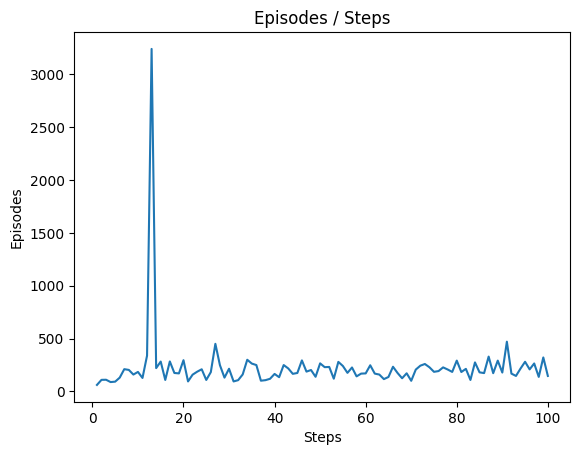

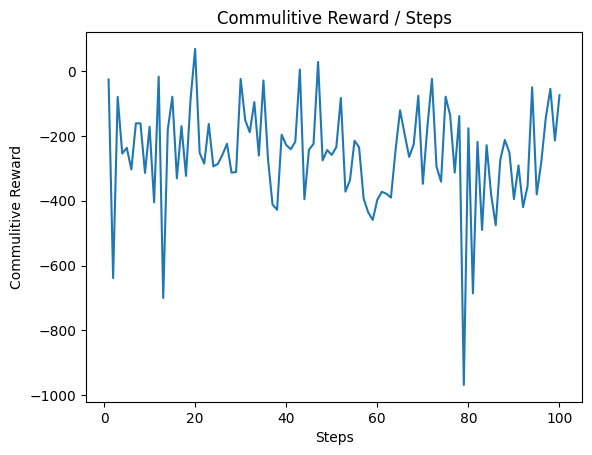

In [ ]:
import matplotlib.pyplot as plt

def graph_for_episodes_with_steps():
  x_axis = steps
  y_axis = total_episodes
  plt.plot(x_axis, y_axis)
  plt.xlabel('Steps')
  plt.ylabel('Episodes')
  plt.title('Episodes / Steps')
  plt.show()

def graph_for_rewards_with_steps():
  x_axis = steps
  y_axis = commulative_rewards

  plt.plot(x_axis, y_axis)
  plt.xlabel('Steps')
  plt.ylabel('Commulitive Reward')
  plt.title('Commulitive Reward / Steps')
  plt.show()

graph_for_episodes_with_steps()
graph_for_rewards_with_steps()


In [ ]:
!ls /content/videos